In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.0 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import imageio.v3 as iio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm
from tqdm.notebook import tqdm
import cv2
import torchmetrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/image_segmentation/train.zip

In [ ]:
!unzip /content/drive/MyDrive/image_segmentation/val.zip

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


## Preprare train and validation for dataset

In [ ]:
# I want a directory of images and their maps 
def vpath2ipath(train_dir):
  train_video_dir = [] # if .png 
  train_video_masks = [] #if npy
  mask_order = []
  for video_nm in tqdm(os.listdir(train_dir)):
    video_path = os.path.join(train_dir, video_nm)
    mask_order.append(video_path)
    video_img = []
    for img_nm in os.listdir(video_path):
      if ("mask" not in img_nm):
        video_img.append(os.path.join(video_path,img_nm))
    video_img = sorted(video_img, key = (lambda x: int(x.split("_")[-1].split(".")[0])))
    train_video_dir.extend(video_img)
  return train_video_dir, mask_order
# Probably handle masks in the training loop

In [ ]:
train_dir = "/content/train"
train_video_dir, mask_order_train = vpath2ipath(train_dir)

In [ ]:
val_dir = "/content/val"
val_video_dir, mask_order_val = vpath2ipath(val_dir)

## Calculate mean and standard deviation

In [ ]:
# def compute_mean_std(image_files):
#     # Get a list of image file paths    
#     # Initialize variables for mean and standard deviation calculation
#     num_images = len(image_files)
#     channel_sum = np.zeros(3)
#     channel_squared_sum = np.zeros(3)
    
#     # Iterate over images
#     for image_file in tqdm(image_files):
#         # Open image and convert to tensor
#         image = Image.open(image_file)
#         image_tensor = ToTensor()(image).numpy()

#         # Accumulate the sum and squared sum of pixel values for each channel
#         channel_sum += np.sum(image_tensor, axis=(1, 2))
#         channel_squared_sum += np.sum(np.square(image_tensor), axis=(1, 2))

#     # Calculate mean and standard deviation
#     mean = channel_sum / (num_images * image_tensor.shape[1] * image_tensor.shape[2])
#     std = np.sqrt(channel_squared_sum / (num_images * image_tensor.shape[1] * image_tensor.shape[2]) - np.square(mean))

#     return mean, std

# # Replace 'path_to_your_image_folder' with the correct path to your image folder
# mean, std = compute_mean_std(img_list)
# print(f"Mean: {mean}")
# print(f"Standard Deviation: {std}")


## Prepare dataset for dataloader

In [ ]:
class UNetDataset(Dataset):
    def __init__(self, img_list, transform1=None, transform2=None):
        self.img_list = img_list
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        image = Image.open(img_name).convert("RGB")

        mask_dir = os.path.join("/".join(img_name.split("/")[:-1]), 'mask.npy')
        mask_idx = int("".join(img_name.split("/")[-1]).split(".")[0].split("_")[1])
        mask = np.load(mask_dir)[mask_idx]

        # Resize for UNet model 
        image_np = np.array(image)
        image_np = cv2.copyMakeBorder(image_np, top=0, bottom=0, left=0, right=16, borderType=cv2.BORDER_CONSTANT, value=0)


        # Resize and pad mask
        mask = cv2.copyMakeBorder(mask, top=0, bottom=0, left=0, right=16, borderType=cv2.BORDER_CONSTANT, value=0)

        

        if self.transform1:
            image = self.transform1(Image.fromarray(image_np))
        mask = torch.tensor(mask, dtype=torch.long) # this transform won't have any to tensor torch.tensor()
        return image, mask

In [ ]:
transform1 = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Data augmentation: color jitter
    transforms.ToTensor(),  # Convert image to tensor
    # transforms.Normalize(mean = [0.50620994, 0.50456696, 0.50085988], std = [0.05694261, 0.05674587, 0.06141094]),
])

In [ ]:
# train loader 
batch_size = 32
img_list = train_video_dir
dataset = UNetDataset(img_list, transform1)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# validation loader 
batch_size = 32
img_list = val_video_dir
dataset = UNetDataset(img_list, transform1)
val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
# Testing out train_dataloader
for _, (image, mask) in enumerate(train_dataloader):
  break

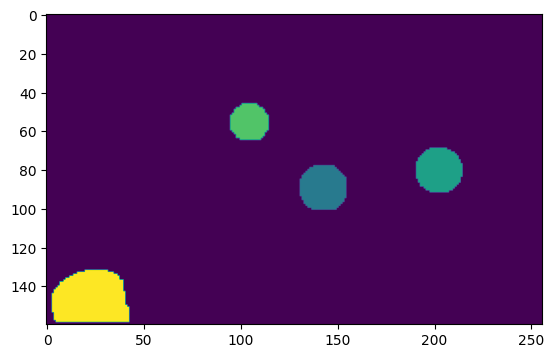

In [ ]:
plt.imshow(mask[21])

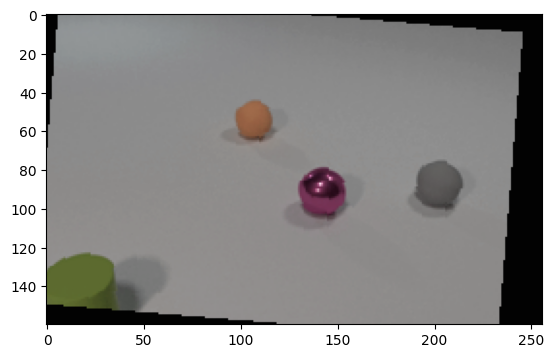

In [ ]:
plt.imshow(image[21].permute(1,2,0))

## U-Net

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",  # Choose an encoder architecture, e.g., "resnet34", "resnet50", "densenet121", etc.
    encoder_weights=None,  # Pretrained weights for the encoder, "imagenet" or None
    in_channels=3,  # Number of input channels
    classes=49,  # Number of output classes
).to(device)

In [ ]:
epochs = 15
criterion = smp.losses.DiceLoss('multiclass').to(device)
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

In [ ]:
best_val_loss = 10000.0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training loop
    model.train()
    train_loss = 0.0
    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    print(f"Train Loss: {train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Validation Loss: {val_loss:.4f}")
    if val_loss<best_val_loss:
      print("best iter so far\n")
      best_val_loss = val_loss
      model_state_dict = model.state_dict(),
      optimizer_state_dict = optimizer.state_dict()

Epoch 1/15
Train Loss: 0.8915
Validation Loss: 0.8335
best iter so far

Epoch 2/15


In [ ]:
torch.save(model.state_dict(), "simple_model.pt")

In [ ]:
#0.128

## Model inference

In [ ]:
# Load the model architecture
model = smp.Unet(
    encoder_name="resnet50",  # Choose an encoder architecture, e.g., "resnet34", "resnet50", "densenet121", etc.
    encoder_weights=None,  # Pretrained weights for the encoder, "imagenet" or None
    in_channels=3,  # Number of input channels
    classes=49,  # Number of output classes
).to(device)

In [ ]:
# Load model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/image_segmentation/simple_model.pt")[0])

<All keys matched successfully>

In [ ]:
# Get the data 
!unzip /content/drive/MyDrive/image_segmentation/hidden_set_for_leaderboard_1.zip

In [ ]:
# Create data loader with sorted list of videos
test_path = '/content/hidden'
test_data = []
for video_nm in tqdm(os.listdir(test_path)):
  test_data.append(os.path.join(test_path, video_nm))
test_data = sorted(test_data, key = (lambda x:int(x.split('_')[-1])))

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# Test dataloader
class UNetDatasetTest(Dataset):
    def __init__(self, video_list, transform1=None):
        self.video_list = video_list
        self.transform1 = transform1

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        video_path = self.video_list[idx]
        img_name = os.path.join(video_path, 'image_10.png')
        image = Image.open(img_name).convert("RGB")

        # Resize for UNet model 
        image_np = np.array(image)
        image_np = cv2.copyMakeBorder(image_np, top=0, bottom=0, left=0, right=16, borderType=cv2.BORDER_CONSTANT, value=0)      

        if self.transform1:
            image = self.transform1(Image.fromarray(image_np))
        return image, img_name

In [ ]:
# transforms
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

In [ ]:
# test loader 
batch_size = 32
dataset = UNetDatasetTest(test_data, transform_test)
test_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Model inference
model.eval()
test_loss = 0
correct = 0
total = 0
result = []
criterion = smp.losses.DiceLoss('multiclass').to(device)

# Iterate over the test dataset
with torch.no_grad():
    for data, dir in tqdm(test_dataloader):
        # Perform a forward pass through the model
        data = data.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        predicted = predicted[:,:,0:240]
        result.append(predicted)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
predictions = torch.cat(result, dim = 0)

In [ ]:
torch.save(predictions, 'predictions.pt')

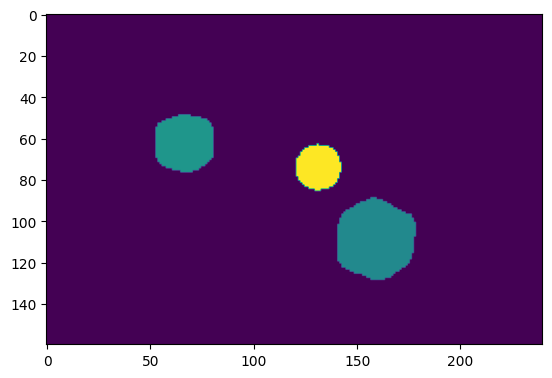

In [ ]:
plt.imshow(predictions[0,:,:].to('cpu'))

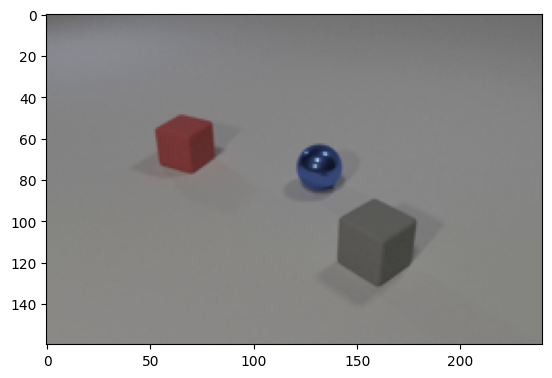

In [ ]:
plt.imshow(Image.open(os.path.join(test_data[0], 'image_10.png')).convert('RGB'))

In [ ]:
predictions = predictions.to(device)
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)
jaccard(predictions[0], predictions[0])

tensor(0.0816, device='cuda:0')